# Geometric Phase Simulation 2

1450-1550nm parameter sweep, and linear polarization

In [11]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
from tidy3d import material_library
import scienceplots

td.config.logging_level = "ERROR"

## Preconditions

In [15]:
# 0 Define a FreqRange object with desired wavelengths
fr = td.FreqRange.from_wvl_interval(wvl_min=1.505, wvl_max=1.515)
N = 701 # num_points
fwidth = fr.fmax - fr.fmin
freq0 = fr.freq0
lda0 = td.C_0 / fr.freq0

In [16]:
# 1 Computational Domain Size
h = 0.210  # Height of cylinder
spc = 8
sh = 3  # height of the SiO2
Lz = spc + h + spc + h

Px = Py = P = 0.750 # periodicity
sim_size = [Px, Py, Lz]

In [17]:
# 2 Grid Resolution
dl = P / 32
horizontal_grid = td.UniformGrid(dl=dl)
vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
grid_spec=td.GridSpec(
    grid_x=horizontal_grid,
    grid_y=horizontal_grid,
    grid_z=vertical_grid,
)

In [18]:
# 3 Structures and Materials
R = 0.235  # radius of the cylinder
r = 0.030  # radius of the inner hole
p = 0.080  # distance between hole to center of circle
theta = np.deg2rad(90) # angle between x-axis and p vector

Si = material_library['cSi']['Green2008']
SiO2 = material_library['SiO2']['Horiba']

outer_cylinder = td.Cylinder(
    center=[0, 0, h / 2], 
    radius=R, 
    length=h, 
    axis=2
)

inner_cylinder = td.Cylinder(
    center=[p*np.cos(theta), -p*np.sin(theta), h / 2], 
    radius=r, 
    length=h, 
    axis=2
)

cylinder = td.ClipOperation(
    operation="difference",
    geometry_a=outer_cylinder,
    geometry_b=inner_cylinder
)

atom = td.Structure(
    geometry=cylinder, 
    medium=Si,
    name="metaatom"
)

dioxide = td.Structure(
    geometry=td.Box(
        center=[0,0,-sh/2],
        size=(td.inf,td.inf, sh)
    ),
    medium=SiO2, 
    name="silicon dioxide"
)

substrate = td.Structure(
    geometry=td.Box(
        center=(0,0,-Lz/2),
        size=(td.inf,td.inf,2 * (spc - (sh - h)))
    ),
    medium=Si,
    name='substrate'
)

In [19]:
source = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=fr.freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz/2 + spc - (sh - h) - 0.5 * lda0),
    direction="+",
    pol_angle=0,
)

In [20]:
monitor = td.FluxMonitor(
    center=(0, 0, Lz/2 - spc + 1.5 * lda0),
    size=(td.inf, td.inf, 0),
    freqs=fr.freqs(N),
    name="flux_monitor"
)

In [22]:
bandwidth = fr.fmax - fr.fmin
# run_time = 50 / bandwidth # run_time for the transmittance simulation

In [23]:
bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

In [24]:
alphas = [10, 50, 100, 150, 200]
run_times = [x / bandwidth for x in alphas]
sims = {}

for i, run_time in enumerate(run_times):
    sim_actual = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[substrate, dioxide, atom],
        sources=[source],
        monitors=[monitor],
        run_time=run_time,
        boundary_spec=bc
    )

    sims[f"actual{i}"] = sim_actual

In [25]:
batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data/geom_lin")

Output()

17:20:50 EDT Started working on Batch containing 5 tasks.

17:20:55 EDT Maximum FlexCredit cost: 7.571 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

17:26:16 EDT Batch complete.

Output()

In [27]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])

x = td.C_0 / fr.freqs(N) * 1000
Ts = []
for i in range(len(alphas)):
    Ts.append(batch_data[f"actual{i}"]["flux_monitor"].flux)

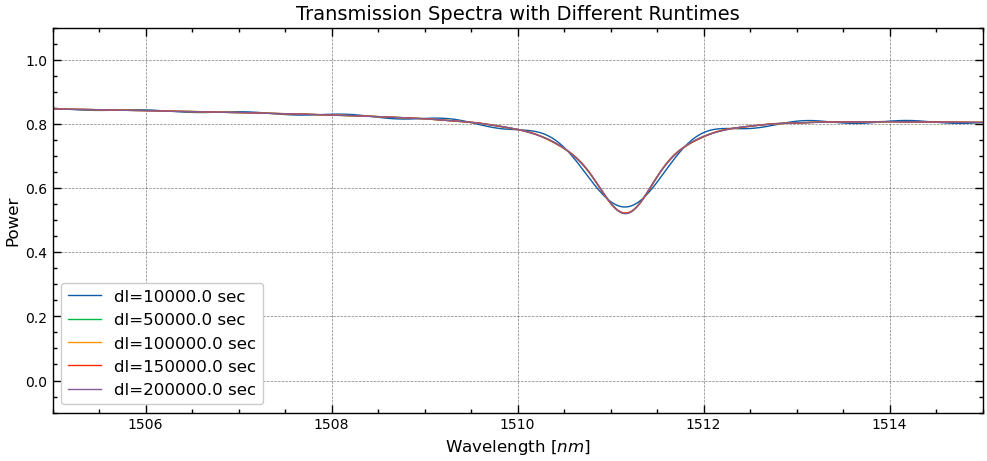

In [29]:
plt.figure(figsize=(12, 5))
for i, T in enumerate(Ts):
    plt.plot(x, T, "-",lw=1, label=f"dl={alphas[i] * 1000:.1f} sec")
plt.xlabel(r"Wavelength [$nm$]", fontsize=12)
plt.ylabel("Power", fontsize=12)
plt.xlim(1505, 1515)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=10) # change tick label size to 10
plt.title("Transmission Spectra with Different Runtimes", fontsize=14)
plt.savefig("runtimes.png", dpi=300)
plt.show()

In [130]:
T_actual = batch_data["actual"]["flux_monitor"].flux 
T_norm = batch_data["norm"]["flux_monitor"].flux

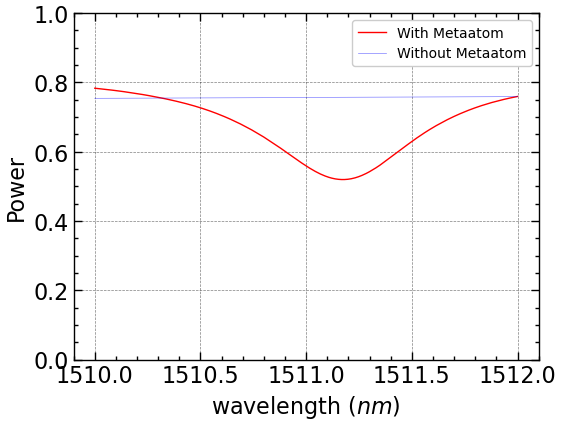

In [131]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, T_actual, "r", lw=1, label="With Metaatom")
plt.plot(td.C_0 / fr.freqs(N) * 1000, T_norm, "b", lw=0.5, alpha=0.5, label="Without Metaatom")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Power")
plt.ylim(0, 1)
plt.legend(fontsize=10)
plt.savefig("power_fine", dpi=300)
plt.show()